In [1]:
%store -r electric_vehicle_df

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
from pingouin import ttest
from scipy import stats
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn import tree

How old are EV and plug-in hybrids in the state? Is there a significant age difference between the two EV types? 

From the electric_vehicle_df we will use only the "Model Year"and "Electric Vehicle Type" to address this question.

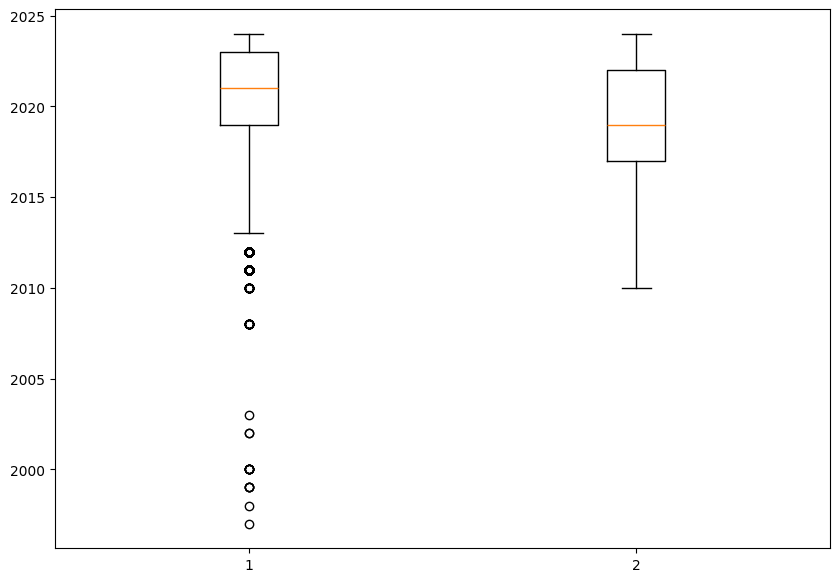

In [3]:
#Select variables from EV data
ev_q4_df = electric_vehicle_df[["Model Year", "Electric Vehicle Type"]]
ev_BEV_df = ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]
ev_PHEV_df = ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]

BEV = ev_BEV_df["Model Year"]
PHEV = ev_PHEV_df["Model Year"]
q4_data = [BEV, PHEV]

#Create boxplot to compare the model year of the EV types
fig = plt.figure(figsize =(10, 7))
plt.boxplot(q4_data)
plt.show()

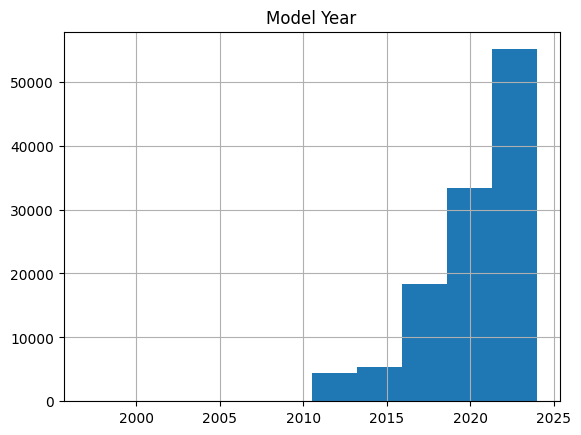

In [4]:
# Plot histogram of BEV model year distribution
ev_BEV_df.hist(column="Model Year");

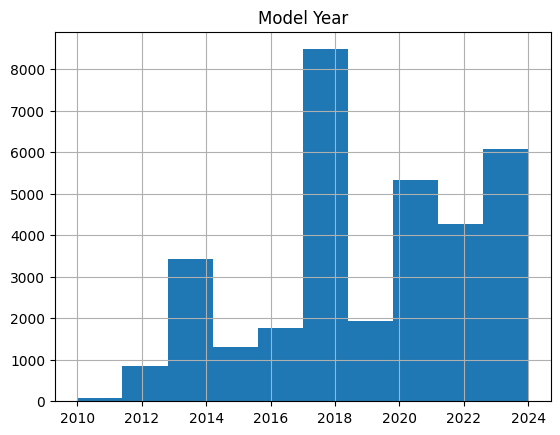

In [5]:
# Plot histogram of PHEV model year distribution
ev_PHEV_df.hist(column="Model Year");

Both BEV and PHEV are skewed to the left. The BEVs have outliers in the earlier years with the highest frequency in the recent years. PHEVs have the highest frequency arpund 2018.

In [6]:
# Summarary statistics for model year by EV type
ev_q4_summary = pd.DataFrame(
    {"EV Type": ["Battery Electric Vehicle (BEV)","Plug-in Hybrid Electric Vehicle (PHEV)"],
     "mean": [ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"].mean().round(2), 
             ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"].mean().round(2)],
     'std dev': [ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"].std(), 
                ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"].std()],
     'N': [len(ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]),
           len(ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"])]
    })
ev_q4_summary

,EV Type,mean,std dev,N
0,Battery Electric Vehicle (BEV),2020.31,2.857224,116585
1,Plug-in Hybrid Electric Vehicle (PHEV),2018.94,3.293162,33556


Variences are not equal so t-test with unpooled variences is used to see if the means are significantly different from each other.

In [7]:
# T-test to compare means for each EV type
ev_q4_test = pd.DataFrame(
                {"Battery Electric Vehicle (BEV)": ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Battery Electric Vehicle (BEV)"]["Model Year"],
                 "Plug-in Hybrid Electric Vehicle (PHEV)": ev_q4_df.loc[ev_q4_df["Electric Vehicle Type"] == "Plug-in Hybrid Electric Vehicle (PHEV)"]["Model Year"]})


ttest(ev_q4_test["Battery Electric Vehicle (BEV)"], ev_q4_test["Plug-in Hybrid Electric Vehicle (PHEV)"], correction = True)

C:\Users\amdur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning: divide by zero encountered in scalar divide
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,69.393475,49008.463712,two-sided,0.0,"[1.34, 1.41]",0.464844,inf,1.0


P-value is less than significance value of 0.05 so we reject the null hypothesis and conclude that the means are different.

In [8]:
ev_q4_test.describe()

,Battery Electric Vehicle (BEV),Plug-in Hybrid Electric Vehicle (PHEV)
count,116585.000000,33556.000000
mean,2020.314534,2018.938491
std,2.857224,3.293162
min,1997.000000,2010.000000
25%,2019.000000,2017.000000
50%,2021.000000,2019.000000
75%,2023.000000,2022.000000
max,2024.000000,2024.000000


In [9]:
ev_q4_df.head()

,Model Year,Electric Vehicle Type
0,2020,Battery Electric Vehicle (BEV)
1,2022,Plug-in Hybrid Electric Vehicle (PHEV)
2,2023,Plug-in Hybrid Electric Vehicle (PHEV)
3,2018,Battery Electric Vehicle (BEV)
4,2018,Plug-in Hybrid Electric Vehicle (PHEV)


Convert the "Electric Vehicle Type" to dummy variable categories for modeling purposes.

In [10]:
# Prepare data for logistic regression model
ev_q4_model_df = ev_q4_df
ev_q4_model_df["Electric Vehicle Type"] = ev_q4_model_df["Electric Vehicle Type"].astype("category")
cat_columns = ev_q4_model_df.select_dtypes(['category']).columns
ev_q4_model_df[cat_columns] = ev_q4_model_df[cat_columns].apply(lambda x: x.cat.codes)
ev_q4_model_df.head()

C:\Users\amdur\AppData\Local\Temp\ipykernel_1760\2498206792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_q4_model_df["Electric Vehicle Type"] = ev_q4_model_df["Electric Vehicle Type"].astype("category")
C:\Users\amdur\AppData\Local\Temp\ipykernel_1760\2498206792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_q4_model_df[cat_columns] = ev_q4_model_df[cat_columns].apply(lambda x: x.cat.codes)


,Model Year,Electric Vehicle Type
0,2020,0
1,2022,1
2,2023,1
3,2018,0
4,2018,1


For the model, 0 represents BEVs and 1 represents PHEVs.

In [11]:
#split dataset in features and target variable
feature_cols = ["Model Year"] 
X = ev_q4_model_df[feature_cols] 
y = ev_q4_model_df["Electric Vehicle Type"] 

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7778345136869214


The model has a good accuracy of 77.78%.

[Text(0.6590909090909091, 0.9375, 'x[0] <= 2018.5\ngini = 0.347\nsamples = 105098\nvalue = [81577, 23521]'),
 Text(0.45454545454545453, 0.8125, 'x[0] <= 2017.5\ngini = 0.463\nsamples = 30829\nvalue = [19631, 11198]'),
 Text(0.4090909090909091, 0.6875, 'x[0] <= 2016.5\ngini = 0.476\nsamples = 20898\nvalue = [12718, 8180]'),
 Text(0.36363636363636365, 0.5625, 'x[0] <= 2014.5\ngini = 0.458\nsamples = 14901\nvalue = [9601, 5300]'),
 Text(0.22727272727272727, 0.4375, 'x[0] <= 2011.5\ngini = 0.485\nsamples = 7534\nvalue = [4411, 3123]'),
 Text(0.09090909090909091, 0.3125, 'x[0] <= 2009.0\ngini = 0.192\nsamples = 605\nvalue = [540, 65]'),
 Text(0.045454545454545456, 0.1875, 'gini = 0.0\nsamples = 25\nvalue = [25, 0]'),
 Text(0.13636363636363635, 0.1875, 'x[0] <= 2010.5\ngini = 0.199\nsamples = 580\nvalue = [515, 65]'),
 Text(0.09090909090909091, 0.0625, 'gini = 0.208\nsamples = 17\nvalue = [15, 2]'),
 Text(0.18181818181818182, 0.0625, 'gini = 0.199\nsamples = 563\nvalue = [500, 63]'),
 Text(0

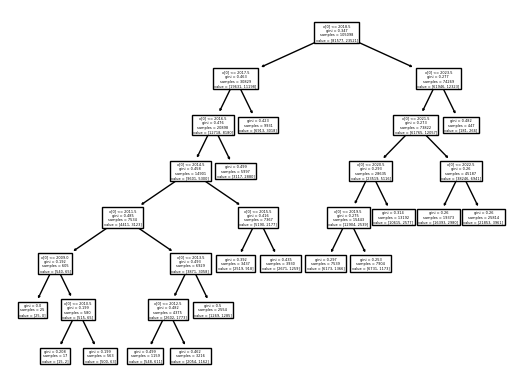

In [12]:
tree.plot_tree(clf)